In [ ]:
! pip install kaggle

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import torch
import torchaudio
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from torch.utils.data import Dataset, DataLoader
import os

from IPython.display import Audio
from tqdm import tqdm

upload your kaggle.json file - you can get it from settings > api > token, assuming you created a kaggle account


In [ ]:
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download mrgabrielblins/speaker-recognition-cmu-arctic

Dataset URL: https://www.kaggle.com/datasets/mrgabrielblins/speaker-recognition-cmu-arctic
License(s): CC0-1.0
100% 1.26G/1.26G [00:07<00:00, 214MB/s]
100% 1.26G/1.26G [00:07<00:00, 184MB/s]


In [ ]:
! unzip speaker-recognition-cmu-arctic

Streaming output truncated to the last 5000 lines.
  inflating: train/ksp/arctic_a0141.wav  
  inflating: train/ksp/arctic_a0142.wav  
  inflating: train/ksp/arctic_a0143.wav  
  inflating: train/ksp/arctic_a0144.wav  
  inflating: train/ksp/arctic_a0145.wav  
  inflating: train/ksp/arctic_a0146.wav  
  inflating: train/ksp/arctic_a0147.wav  
  inflating: train/ksp/arctic_a0148.wav  
  inflating: train/ksp/arctic_a0149.wav  
  inflating: train/ksp/arctic_a0150.wav  
  inflating: train/ksp/arctic_a0152.wav  
  inflating: train/ksp/arctic_a0153.wav  
  inflating: train/ksp/arctic_a0154.wav  
  inflating: train/ksp/arctic_a0155.wav  
  inflating: train/ksp/arctic_a0156.wav  
  inflating: train/ksp/arctic_a0157.wav  
  inflating: train/ksp/arctic_a0158.wav  
  inflating: train/ksp/arctic_a0159.wav  
  inflating: train/ksp/arctic_a0160.wav  
  inflating: train/ksp/arctic_a0162.wav  
  inflating: train/ksp/arctic_a0163.wav  
  inflating: train/ksp/arctic_a0165.wav  
  inflating: train/ksp/ar

In [ ]:
train_df = pd.read_csv('train.csv')
train_df.head()

,id,file_path,speech,speaker
0,rxr_a0591,train/rxr/arctic_a0591.wav,We are both children together.,rxr
1,rxr_a0403,train/rxr/arctic_a0403.wav,His newborn cunning gave him poise and control.,rxr
2,ljm_a0059,train/ljm/arctic_a0059.wav,His immaculate appearance was gone.,ljm
3,jmk_a0134,train/jmk/arctic_a0134.wav,He obeyed the pressure of her hand.,jmk
4,rms_b0067,train/rms/arctic_b0067.wav,Below him the shadow was broken into a pool of...,rms


In [ ]:
train_df['speaker'].value_counts()

,count
speaker,
awb,910
rms,906
aew,906
slt,906
clb,906
ksp,906
bdl,905
lnh,905
jmk,891


In [ ]:
# view the unique classes (speakers)
speakers = list(train_df['speaker'].unique())

# convert categorical values into numerical values
train_df['speaker'] = train_df['speaker'].apply(lambda x: speakers.index(x))
train_df['speaker'].value_counts()

,count
speaker,
6,910
3,906
15,906
13,906
7,906
5,906
9,905
10,905
2,891


In [ ]:
# remove unnecessary columns
train_df = train_df[['file_path','speaker']]
train_df.head()

,file_path,speaker
0,train/rxr/arctic_a0591.wav,0
1,train/rxr/arctic_a0403.wav,0
2,train/ljm/arctic_a0059.wav,1
3,train/jmk/arctic_a0134.wav,2
4,train/rms/arctic_b0067.wav,3


In [ ]:
max_length = 16000
for index, path in tqdm(train_df.iterrows()):
  audio_sample_path = train_df.iloc[index,0]
  waveform, sample_rate = torchaudio.load(audio_sample_path)
  length = len(waveform[0])
  if length > max_length:
    max_length = length

12466it [01:46, 116.65it/s]


In [ ]:
max_length // 16000
# given the sample rate of 16000, the longest running file is ~7 seconds long

7

In [ ]:
audio_sample_path = train_df.iloc[1, 0]
waveform, sample_rate = torchaudio.load(audio_sample_path)
Audio(waveform, rate=sample_rate)

In [ ]:
waveform.shape

torch.Size([1, 63581])

In [ ]:
#padding
zeros = torch.zeros(max_length - len(waveform[0]))
waveform = torch.cat((waveform[0], zeros))
waveform.shape

torch.Size([122641])

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


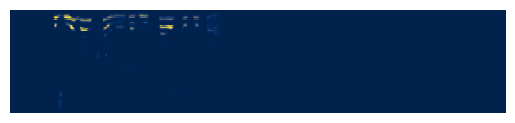

<ipython-input-15-811e2c8d1e3e>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resized_rgb_image = resize(torch.tensor(rgb_tensor))


rgb_shape: (128, 614, 4)
original_shape: torch.Size([128, 614, 3])
tensor shape: torch.Size([1, 3, 128, 614])
before permute: torch.Size([3, 224, 224])
final shape: torch.Size([224, 224, 3])


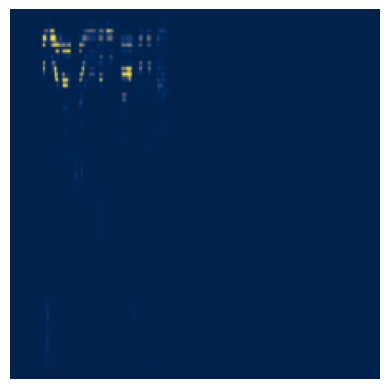

In [ ]:
mel_spec = torchaudio.transforms.MelSpectrogram(normalized = True)
spectrogram = mel_spec(waveform)

# Apply a colormap to map values to colors
cmap = cm.cividis  # You can choose any colormap you prefer
rgb_image = cmap(spectrogram)  # Convert the single-channel spectrogram to RGB using the colormap

# Display the RGB image
plt.imshow(rgb_image)
plt.axis('off')
plt.show()

#to resize to (224,224)
resize = transforms.Resize((224, 224))
print(f'rgb_shape: {rgb_image.shape}')

rgb_image = rgb_image[:,:,:3]
rgb_tensor = torch.from_numpy(rgb_image)
print(f'original_shape: {rgb_tensor.shape}')
rgb_tensor = rgb_tensor.permute(2,0,1)
rgb_tensor = rgb_tensor.unsqueeze(0)
print(f'tensor shape: {rgb_tensor.shape}')
resized_rgb_image = resize(torch.tensor(rgb_tensor))
resized_rgb_image = resized_rgb_image.squeeze(0)
print(f'before permute: {resized_rgb_image.shape}')
resized_rgb_image = resized_rgb_image.permute(1,2,0)
print(f'final shape: {resized_rgb_image.shape}')



[224,224]
[0,224,224]

# 'resized_rgb_image' is now resized to (224, 224) with colors based on the colormap
plt.imshow(resized_rgb_image)
plt.axis('off')
plt.show()

In [ ]:
sample_rate

16000

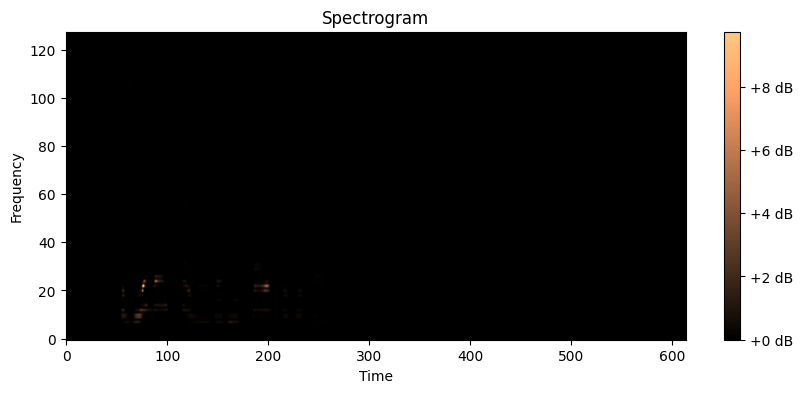

In [ ]:
plt.figure(figsize=(10, 4))
plt.imshow(spectrogram, cmap='copper', origin='lower', aspect='auto')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

In [ ]:
class SpeechDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
      return len(self.df)

    def __getitem__(self, index):
        audio_sample_path = self.df.iloc[index, 0]
        waveform, sample_rate = torchaudio.load(audio_sample_path)
        waveform = waveform.squeeze(0)

        #padding
        if len(waveform) < max_length:
          zeros = torch.zeros(max_length - len(waveform))
          waveform = torch.cat((waveform, zeros))
        else:
          waveform = waveform[:max_length]

        #apply transforms (into mel spectrogram)
        if self.transform:
          mel_spec = torchaudio.transforms.MelSpectrogram(normalized = True, n_mels= 64)
          resize = torchvision.transforms.Resize((224, 224))
          spectrogram = mel_spec(waveform)

          # Apply a colormap to map values to colors
          cmap = cm.cividis  # You can choose any colormap you prefer
          rgb_image = cmap(spectrogram)  # Convert the single-channel spectrogram to RGB using the colormap

          rgb_image = rgb_image[:,:,:3]
          rgb_tensor = torch.from_numpy(rgb_image)
          rgb_tensor = rgb_tensor.permute(2,0,1)
          rgb_tensor = rgb_tensor.unsqueeze(0)

          resized_rgb_image = resize(torch.tensor(rgb_tensor, dtype = torch.float32))
          resized_rgb_image = resized_rgb_image.squeeze(0)


        inputs = resized_rgb_image
        targets = self.df.iloc[index,1]
        return inputs, targets

transform = transforms.Compose([torchaudio.transforms.MelSpectrogram(normalized = True),
                                 torchvision.transforms.Resize((224, 224)),
                                 torchvision.transforms.ToTensor()])

In [ ]:
test_df = pd.read_csv('test_full.csv')
test_df = test_df[['file_path','speaker']]

# turn categorical data into numerical data, this time for the test dataframe
test_df['speaker'] = test_df['speaker'].apply(lambda x: speakers.index(x))

In [ ]:
train_data = SpeechDataset(train_df, transform=transform)
test_data = SpeechDataset(test_df, transform=transform)

In [ ]:
train_loader = DataLoader(train_data, batch_size = 32, shuffle = True )
test_loader = DataLoader(test_data, batch_size = 32, shuffle = True )

In [ ]:
num_classes = len(train_df['speaker'].unique())

model = torchvision.models.vgg19(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 229MB/s]


In [ ]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
model.classifier[6] = nn.Linear(4096, num_classes)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 3e-4)
num_epochs = 10


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # Testing phase
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss/ len(test_loader)
    print(f'Epoch: {epoch+1} / {num_epochs}, Train loss: {avg_train_loss:.4f}, Test accuracy: {avg_test_loss:.4f}')


  0%|          | 0/390 [00:00<?, ?it/s]<ipython-input-18-59930cccd5e8>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resized_rgb_image = resize(torch.tensor(rgb_tensor, dtype = torch.float32))
100%|██████████| 390/390 [27:52<00:00,  4.29s/it]


Epoch: 1 / 20, Train loss: 0.9540, Test accuracy: 0.2109


100%|██████████| 390/390 [27:44<00:00,  4.27s/it]


Epoch: 2 / 20, Train loss: 0.2344, Test accuracy: 0.1683


100%|██████████| 390/390 [28:11<00:00,  4.34s/it]
